# Validating Models on Hierarchical Data

Most toy machine‑learning examples assume each row in a dataset is an independent draw. But real‑world data are rarely so neat. In this notebook, each observation is an individual *trip*, but trips are nested inside *households*. That means multiple rows in the dataset are related: they share unobserved characteristics and similar values for many features.

If we split or shuffle the data randomly – ignoring this structure – we risk placing trips from the same household in both the training and test sets. As a result, information specific to one household can leak from train to test, inflating performance metrics and giving us an overly confident sense of generalisation. Worse, this can lead to models that fail in real-world deployment.

To evaluate generalisation properly, we usually split our dataset into separate parts. One part is used to train the model. Another is set aside to guide choices about hyper‑parameters or model selection. A final part is kept completely untouched until the very end to provide a fair, unbiased evaluation. These splits are commonly called the **train**, **validation**, and **test** sets.

The **validation set** is often carved out of the training data, either as a single hold‑out slice or through **K‑fold cross‑validation**, where each fold takes a turn as validation while the others form the training data.

All of these methods assume the rows are independent, but when data is hierarchical, that assumption breaks – so our validation strategy needs to be adapted accordingly.

In the rest of this notebook, we’ll revisit those familiar splits – first using random rows, then keeping whole households intact – to observe the effects of ignoring versus respecting the data’s hierarchical structure.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, model_selection
from scipy.stats import randint

## Travel Survey Dataset
The dataset used in this notebook is drawn from a travel survey. Each row corresponds to a single trip made by an individual, and each individual belongs to a specific household. This creates a hierarchical structure in which trips are nested within people, and people are nested within households.

The dataset includes:
- **Trip-level features**, such as distance, time of travel, and weather conditions (e.g. temperature, precipitation, wind).
- **Individual-level attributes**, like age, gender, education level, income group, driving license status, and ethnicity.
- **Household-level attributes**, including household ID, number of cars and bicycles, green space, etc.
- **Target variable**: the main mode of transport chosen for the trip (e.g. walk, car, public transport, bicycle).

This structure makes the dataset particularly well-suited for exploring how standard machine-learning practices – such as train/test splitting and cross-validation – behave when the data independence assumption is violated.

Let’s first load the data and inspect it – notice nested structure of the data mentioned above.

In [4]:
df_full = pd.read_csv("./../data/travel_mode.csv")
df_full.head(10)

,household_id,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind,mode_main
0,7875,1.0,1.26259,84,no,native,lower,less20,0,yes,1,yes,1.24604,26.881233,0.1,0.10,3.0,walk
1,7875,10.0,1.26259,84,no,native,lower,less20,0,yes,1,yes,1.24604,26.881233,0.1,0.10,3.0,walk
2,14449,3.0,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8,car
3,14449,3.0,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8,car
4,14449,61.5,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8,car
5,14449,61.5,0.88025,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8,car
6,19452,0.5,1.83997,47,yes,native,lower,less20,0,yes,3,yes,1.72325,36.698977,-2.2,0.05,2.5,walk
7,19452,0.5,2.15367,47,yes,native,lower,less20,0,yes,3,yes,1.72325,36.698977,-2.2,0.05,2.5,walk
8,10039,0.4,1.18075,31,yes,native,middle,20to40,1,yes,2,yes,1.33844,82.758365,-1.0,0.00,2.5,walk
9,10706,5.0,2.17375,65,no,native,lower,less20,1,yes,2,yes,1.36730,33.290612,0.2,2.20,1.8,car


Some of the features are categorical, with categories represented as strings such as "car", "bike", "walk", etc. We first need to convert these to numerical values before we can use them in a machine-learning model.

In [5]:
categorical_columns = [
    "male",
    "license",
    "weekend",
    "education",
    "income",
    "ethnicity",
    "mode_main",
]

for column in categorical_columns:
    # Convert categorical columns to numerical codes
    df_full[column] = pd.Categorical(df_full[column], ordered=True).codes

df_full.head(10)

,household_id,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind,mode_main
0,7875,1.0,1.26259,84,0,0,1,1,0,1,1,1,1.24604,26.881233,0.1,0.10,3.0,3
1,7875,10.0,1.26259,84,0,0,1,1,0,1,1,1,1.24604,26.881233,0.1,0.10,3.0,3
2,14449,3.0,1.76264,27,1,2,2,0,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8,1
3,14449,3.0,1.76264,27,1,2,2,0,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8,1
4,14449,61.5,1.76264,27,1,2,2,0,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8,1
5,14449,61.5,0.88025,27,1,2,2,0,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8,1
6,19452,0.5,1.83997,47,1,0,1,1,0,1,3,1,1.72325,36.698977,-2.2,0.05,2.5,3
7,19452,0.5,2.15367,47,1,0,1,1,0,1,3,1,1.72325,36.698977,-2.2,0.05,2.5,3
8,10039,0.4,1.18075,31,1,0,2,0,1,1,2,1,1.33844,82.758365,-1.0,0.00,2.5,3
9,10706,5.0,2.17375,65,0,0,1,1,1,1,2,1,1.36730,33.290612,0.2,2.20,1.8,1


### Test (hold-out) set

Let’s set aside some data we are not going to look at until the very end. We’ll use this to understand how the models we train generalise to new, unseen data.

We set aside 20% of the _households_ for this purpose, and use the rest for developing our models.

In [6]:
unique_household_ids = df_full.household_id.unique()
n_holdout_ids = int(len(unique_household_ids) * 0.2)

# choose 10% of the unique household ids to be in the holdout set
rng = np.random.default_rng(seed=42)
holdout_household_ids = rng.choice(
    unique_household_ids, size=n_holdout_ids, replace=False
)

df_holdout = df_full[df_full.household_id.isin(holdout_household_ids)]

# exclude the holdout household ids from the data
df = df_full[~df_full.household_id.isin(holdout_household_ids)]

# let's look at one particular household
df[df.household_id == 3460]

,household_id,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind,mode_main
14,3460,1.0,2.61713,24,0,0,2,0,1,1,3,1,1.02295,22.163588,-1.0,0.0,2.5,3
15,3460,0.5,2.61713,24,0,0,2,0,1,1,3,1,1.02295,22.163588,-1.0,0.0,2.5,3
16,3460,0.5,5.26579,24,0,0,2,0,1,1,3,1,1.02295,22.163588,-1.0,0.0,2.5,3
17,3460,0.5,5.26579,24,0,0,2,0,1,1,3,1,1.02295,22.163588,-1.0,0.0,2.5,3
207379,3460,4.0,2.61713,25,0,0,2,0,1,0,3,0,1.02295,22.163588,5.5,0.0,2.1,0
207380,3460,4.0,1.01444,25,0,0,2,0,1,0,3,0,1.02295,22.163588,5.5,0.0,2.1,0


It‘s easy to notice that people in the same household often take several trips. These trips usually look very similar  –  both in the things we measure (like how far the trip is or what the weather is like) and in the way the person travels. For example, if one person in a household walks to school or work, they might always take the same route and travel the same way. The same goes for things like how many cars or bikes a household owns – that stays the same across all trips from that household.

Take household 3460 as an example. A 24-year-old woman in that household made four trips. She walked every time, and nearly all the details about those trips were the same. Only the distance and how crowded the area was changed a little. Patterns like this show up a lot in the data.

Because many trips from the same person or household look the same, the dataset has what we call a *hierarchical structure*. That means the trips are grouped or “nested” inside people and households, and they’re not completely separate from each other. This matters when we build models to make predictions.

### Why this matters

When we build machine learning models, we often split the data into two or three parts – one to train the model, one to test it, and sometimes one to help tune the model. These splits usually assume that each row of data is independent – that nothing in one row tells us anything about the others.

But if we split the data randomly, we might accidentally put some trips from the same household in both the training and the test set. That creates **data leakage**. The model might seem to perform well, not because it found useful patterns, but because it already saw very similar examples during training.

This can lead us to believe our model is better than it really is. It also means the model might just memorise details about certain households instead of learning patterns that apply to new ones.

In [7]:
print(
    "There are {} trips made by {} households in the data. "
    "The average number of trips recorded per household is {:.2f} and the median {:.0f}.".format(
        len(df),
        len(df.household_id.unique()),
        df.groupby("household_id").size().mean(),
        df.groupby("household_id").size().median(),
    )
)

There are 184899 trips made by 36030 households in the data. The average number of trips recorded per household is 5.13 and the median 4.


The majority of households in the dataset have at least 4 trips recorded (median=4). This means it’s very likely that a random train/test split will place different trips from the same household in both sets.

That’s a problem. It introduces correlations between the training and test data that are specific to a household – not general patterns we want the model to learn. As a result, the model might appear more accurate than it really is.


## Random sampling

To see this in action, we’ll train a model that’s deliberately prone to overfitting: a decision tree with no restriction on depth. We'll begin by splitting the data randomly at the trip level. Variables and results that use this strategy will be marked with the suffix `_r` for random.

In [8]:
y = df.mode_main
household_id = df.household_id
X = df.drop(["mode_main", "household_id"], axis=1)

In [9]:
X_train_r, X_test_r, y_train_r, y_test_r = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42
)

Then we can create our candidate model. We'll use standard parameters, except we will not restrict the tree depth.

In [10]:
clf_r = RandomForestClassifier(max_depth=None, n_jobs=-1)
clf_r.fit(X_train_r, y_train_r)

RandomForestClassifier(n_jobs=-1)

Let’s define a function to compute some metrics for our model, and take a look at the results.

In [11]:
def classification_metrics(y_test, y_pred, y_probs, name=None):
    """
    Calculate classification metrics for a single classifier and return as a Series.
    """
    # Calculate metrics
    metrics_dict = {
        "Accuracy": metrics.accuracy_score(y_test, y_pred),
        "Precision": metrics.precision_score(y_test, y_pred, average="weighted"),
        "Recall": metrics.recall_score(y_test, y_pred, average="weighted"),
        "F1-Score": metrics.f1_score(y_test, y_pred, average="weighted"),
        "Log Loss": metrics.log_loss(y_test, y_probs),
        "Average Precision": metrics.average_precision_score(
            y_test, y_probs, average="weighted"
        ),
    }

    # Convert to DataFrame
    metrics_df = pd.Series(metrics_dict, name=name)
    return metrics_df

In [12]:
# generate categorical predictions
y_pred_r = clf_r.predict(X_test_r)

# generate class probabilities
y_probs_r = clf_r.predict_proba(X_test_r)

metrics_r = classification_metrics(
    y_test_r, y_pred_r, y_probs_r, name="Random Sampling"
)
metrics_r

Accuracy             0.820191
Precision            0.817595
Recall               0.820191
F1-Score             0.814520
Log Loss             0.573823
Average Precision    0.880464
Name: Random Sampling, dtype: float64

We now have a set of baseline scores to compare against. Because we did not restrict the depth of our decision tree, the model is probably overfitting – learning patterns that are too specific to the training data, including household-specific details. When trips from the same household appear in both the training and test sets, this creates data leakage: the model appears to perform well, even though it may just be memorising the training data.

## Grouped sampling

So, how do we split the data in a smarter way when we know it has this kind of structure?

The `sklearn` library gives us a helpful tool: `GroupShuffleSplit`, which is part of the `model_selection` module. You can read more about it [here](https://sklearn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html).

Because we’re doing hold-out validation (just one split between train and test), we’ll set `n_splits=1`. Most importantly, we’ll tell the splitter to group by household using the `household_id` Series.

We’ll label any variables or results from this grouped strategy with `_g` to keep track.

In [13]:
gss = model_selection.GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=household_id))

X_train_g, X_test_g, y_train_g, y_test_g = (
    X.iloc[train_idx],
    X.iloc[test_idx],
    y.iloc[train_idx],
    y.iloc[test_idx],
)

household_id_train_g, household_id_test_g = (
    household_id.iloc[train_idx],
    household_id.iloc[test_idx],
)

clf_g = RandomForestClassifier(max_depth=None, n_jobs=-1)
clf_g.fit(X_train_g, y_train_g)

RandomForestClassifier(n_jobs=-1)

Let’s compute the metrics for the new model.

In [14]:
y_pred_g = clf_g.predict(X_test_g)
y_probs_g = clf_g.predict_proba(X_test_g)

metrics_g = classification_metrics(y_test_g, y_pred_g, y_probs_g, "Groupe Sampling")

pd.concat([metrics_r, metrics_g], axis=1)

,Random Sampling,Groupe Sampling
Accuracy,0.820191,0.678307
Precision,0.817595,0.661916
Recall,0.820191,0.678307
F1-Score,0.814520,0.661846
Log Loss,0.573823,0.833938
Average Precision,0.880464,0.716959


The comparison between random and grouped sampling reveals just how much data leakage can distort our understanding of model performance.

When we split trips randomly, the model achieves high scores across the board: accuracy, precision, recall, and even average precision are all in the 81–88% range. But this is misleading. Because trips from the same household appear in both train and test sets, the model benefits from household-specific signals that won't generalise to new, unseen households.

Once we switch to grouped sampling – ensuring that no household appears in both sets – the picture changes dramatically. Accuracy drops from 82% to 68%, and all other metrics fall as well. Log loss increases, reflecting greater uncertainty in the model’s predictions. This tells us that a large part of the model’s earlier performance was due to leakage, not true generalisation.

These results make clear why it’s essential to respect the structure of hierarchical data. Ignoring it can lead to overconfident metrics and misleading conclusions about a model’s real-world usefulness.



## Cross-validation

So far, we’ve seen that random sampling gives misleadingly high metrics, while grouped sampling gives a more honest picture of how well our model generalises. But our grouped model was trained with fixed hyperparameters – we haven’t yet asked whether those choices were optimal.

To explore that, we’ll now run a small hyperparameter search using **group-aware cross-validation**. This lets us estimate performance across multiple splits of the training data, while still making sure that no household appears in more than one fold.

To avoid data leakage across folds, we use [`GroupKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) from `sklearn`, which works just like regular K-fold CV but ensures that no group (in our case, no household) appears in more than one fold.

We’ll combine this with `RandomizedSearchCV` to explore a few combinations of hyperparameters. The goal here isn’t to find the perfect model, but to see how a bit of tuning within a group-aware framework compares to our earlier results.

Let’s set up the grouped cross-validation and search space. We’ll use the same train/test split as in the previous section.



In [15]:
clf_cv = RandomForestClassifier(n_jobs=-1)

In [16]:
params = {
    "max_depth": randint(3, 10),
    "max_features": randint(3, 10),
    "n_estimators": randint(20, 200),
}

gcv = model_selection.GroupKFold(n_splits=3).split(
    X_train_g, y_train_g, groups=household_id_train_g
)
rs = model_selection.RandomizedSearchCV(
    clf_cv,
    param_distributions=params,
    n_iter=5,
    scoring=["accuracy", "neg_log_loss"],
    n_jobs=1,
    cv=gcv,
    refit="neg_log_loss",
    verbose=3,
    random_state=42,
)
rs.fit(X_train_g, y_train_g)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END max_depth=9, max_features=6, n_estimators=112; accuracy: (test=0.682) neg_log_loss: (test=-0.762) total time=   1.3s
[CV 2/3] END max_depth=9, max_features=6, n_estimators=112; accuracy: (test=0.686) neg_log_loss: (test=-0.760) total time=   1.2s
[CV 3/3] END max_depth=9, max_features=6, n_estimators=112; accuracy: (test=0.688) neg_log_loss: (test=-0.755) total time=   1.2s
[CV 1/3] END max_depth=9, max_features=5, n_estimators=91; accuracy: (test=0.681) neg_log_loss: (test=-0.770) total time=   0.9s
[CV 2/3] END max_depth=9, max_features=5, n_estimators=91; accuracy: (test=0.685) neg_log_loss: (test=-0.766) total time=   0.9s
[CV 3/3] END max_depth=9, max_features=5, n_estimators=91; accuracy: (test=0.687) neg_log_loss: (test=-0.760) total time=   0.9s
[CV 1/3] END max_depth=7, max_features=7, n_estimators=122; accuracy: (test=0.678) neg_log_loss: (test=-0.774) total time=   1.3s
[CV 2/3] END max_depth=7, max_fea

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001F647B59BE0>,
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=5,
                   n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F64502A900>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F647B44410>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F647B442D0>},
                   random_state=42, refit='neg_log_loss',
                   scoring=['accuracy', 'neg_log_loss'], verbose=3)

In [17]:
clf_cv_pred = rs.predict(X_test_g)
clf_cv_probs = rs.predict_proba(X_test_g)

metrics_cv = classification_metrics(
    y_test_g, clf_cv_pred, clf_cv_probs, name="Group KFold CV"
)
pd.concat([metrics_r, metrics_g, metrics_cv], axis=1)

,Random Sampling,Groupe Sampling,Group KFold CV
Accuracy,0.820191,0.678307,0.679068
Precision,0.817595,0.661916,0.663967
Recall,0.820191,0.678307,0.679068
F1-Score,0.814520,0.661846,0.660574
Log Loss,0.573823,0.833938,0.764865
Average Precision,0.880464,0.716959,0.725726


We can see that even a small amount of tuning can improve the model’s performance, and a wider search might reveal even better hyperparameters.

## New Data

Recall that in the beginning of the notebook, we set aside some data that we haven’t touched yet. This simulates a real-world scenario where we want to evaluate how well our model generalises to completely new data. Let’s use the models we trained earlier to make predictions on this new data.

In [18]:
# Generate predictions and probabilities for the hold-out set
y_holdout = df_holdout["mode_main"]
X_holdout = df_holdout.drop(["mode_main", "household_id"], axis=1)

# Predictions and probabilities for clf_r
y_pred_r_holdout = clf_r.predict(X_holdout)
y_probs_r_holdout = clf_r.predict_proba(X_holdout)

# Predictions and probabilities for clf_g
y_pred_g_holdout = clf_g.predict(X_holdout)
y_probs_g_holdout = clf_g.predict_proba(X_holdout)

# Predictions and probabilities for clf_cv
y_pred_cv_holdout = rs.predict(X_holdout)
y_probs_cv_holdout = rs.predict_proba(X_holdout)

# Calculate metrics for each classifier
metrics_r_holdout = classification_metrics(
    y_holdout, y_pred_r_holdout, y_probs_r_holdout, name="Random Sampling"
)
metrics_g_holdout = classification_metrics(
    y_holdout, y_pred_g_holdout, y_probs_g_holdout, name="Grouped Sampling"
)
metrics_cv_holdout = classification_metrics(
    y_holdout, y_pred_cv_holdout, y_probs_cv_holdout, name="Group KFold CV"
)

# Combine and display the results
pd.concat([metrics_r_holdout, metrics_g_holdout, metrics_cv_holdout], axis=1)

,Random Sampling,Grouped Sampling,Group KFold CV
Accuracy,0.686736,0.688333,0.690214
Precision,0.671663,0.672914,0.675334
Recall,0.686736,0.688333,0.690214
F1-Score,0.670907,0.672191,0.672516
Log Loss,0.817403,0.820785,0.753847
Average Precision,0.724257,0.722071,0.731825


Now that we’ve evaluated our models on the held-out data, we can assess how well their earlier performance estimates hold up on truly unseen households.

Both the grouped baseline model and the group-tuned model perform similarly on the held-out set as they did during development. This consistency suggests that group-aware validation strategies provide reliable estimates of real-world generalisation. It also shows that tuning with grouped cross-validation yields improvements that carry over to new data – not just within the cross-validation folds.

In contrast, the model trained using random sampling achieved much higher scores during development, but those gains didn’t hold up. When tested on households it hadn’t seen before, its performance dropped to match the other models. This reinforces what we observed earlier: ignoring the data’s hierarchical structure can give a misleading impression of model quality.



## Feature Importance

Finally, we can investigate which features were most important in the three different classifiers. The following cell plots bar charts of the feature importances for each classifier.

Text(0.5, 0, 'Relative Feature Importance')

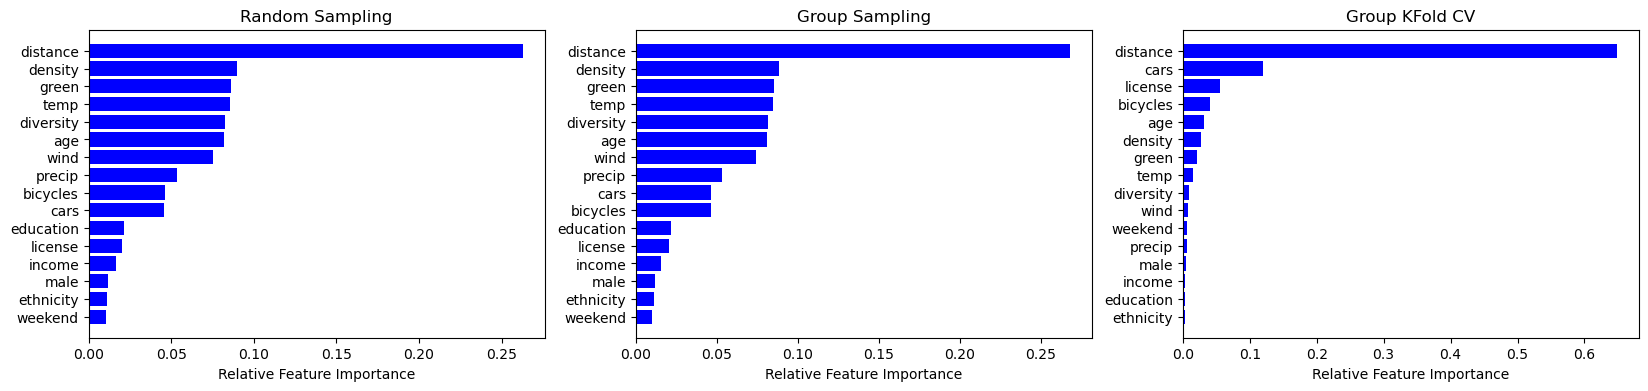

In [19]:
features = X.columns
importances_r = clf_r.feature_importances_
importances_g = clf_g.feature_importances_
importances_cv = rs.best_estimator_.feature_importances_

indices_r = np.argsort(importances_r)
indices_g = np.argsort(importances_g)
indices_cv = np.argsort(importances_cv)

fig, ax = plt.subplots(1, 3, figsize=(20, 4))


ax[0].set_title("Random Sampling")
ax[0].barh(range(len(indices_r)), importances_r[indices_r], color="b", align="center")
ax[0].set_yticks(range(len(indices_r)))
ax[0].set_yticklabels(features[indices_r])
ax[0].set_xlabel("Relative Feature Importance")

ax[1].set_title("Group Sampling")
ax[1].barh(range(len(indices_g)), importances_g[indices_g], color="b", align="center")
ax[1].set_yticks(range(len(indices_g)))
ax[1].set_yticklabels(features[indices_g])
ax[1].set_xlabel("Relative Feature Importance")

ax[2].set_title("Group KFold CV")
ax[2].barh(
    range(len(indices_cv)), importances_cv[indices_cv], color="b", align="center"
)
ax[2].set_yticks(range(len(indices_cv)))
ax[2].set_yticklabels(features[indices_cv])
ax[2].set_xlabel("Relative Feature Importance")

These feature importance plots show how structure-aware validation shapes what the model learns.

With random sampling or grouped holdout, the model relies heavily on group-specific features like green space. Only with Group K-Fold cross-validation do we see a shift: the model starts focusing on features like number of cars or license status – signals that generalise better.

In short, when we validate properly, we train more robust models.